### Using GP prior for regularization of heat MAP not for regression. Note that I never obseve any value. 
This induces coarsening till the lenght scale of the prior.

# KL MULTIVARIATE GAUSSIAN 

The prior is a multivariate Gaussian (GP). 
The covariance matrix is decomposed only once (at the beginning) as cov1 = L1 L1^T by cholesky decomposition
The posterior is a DIAGONAL Normal distribution, therefore cov0 = L0 L0^T = diagonal means that L0 = diag(sigma) 
can be compute at each iteration very cheaply. I have simple analytical expression for the KL_divergence of two multivariate gaussian in terms of mu0, L0, mu1, L1 
Therefore I can frame everyting in the usual VAE framework with KL(posterio|prior) + RECONSTRUCTION

Implement the KL between two distribution for the special case of posterior (i.e. N0) being diagonal and prior (i.e. N1) being a GP which means that the covariance cna be calculated using the Kernel
<img src="KL_multivariate_gaussian.png">

### IMPORT NECESSARY MODULES

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from IPython.core.display import display, HTML, Image
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D 

import os, glob
from functools import partial
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal
import numpy as np
from torchvision import utils
from typing import Optional
from collections import namedtuple 

def show_batch(images: torch.Tensor,
               n_col: int = 4,
               n_padding: int = 10,
               title: Optional[str] = None,
               pad_value: int = 1):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    assert len(images.shape) == 4  # batch, ch, width, height
    if images.device != "cpu":
        images = images.cpu()
    grid = utils.make_grid(images, n_col, n_padding, normalize=True, range=(0.0, 1.0),
                           scale_each=False, pad_value=pad_value)
        
    fig = plt.figure()
    plt.imshow(grid.detach().numpy().transpose((1, 2, 0)))
    if isinstance(title, str):
        plt.title(title)
    plt.close(fig)
    fig.tight_layout()
    return fig

def are_boradcastable(a: torch.Tensor, b: torch.Tensor) -> bool:
    return all((m == n) or (m == 1) or (n == 1) for m, n in zip(a.shape[::-1], b.shape[::-1]))

# Example of plotting 3D surfaces

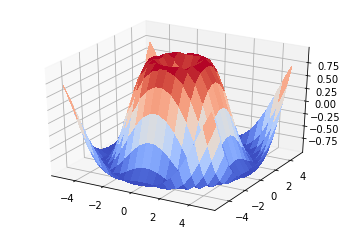

In [37]:
xv, yv = torch.meshgrid([torch.linspace(-5.0,5.0,20), torch.linspace(-5.0,5.0,20)])
zv = torch.sin(torch.sqrt(xv**2 + yv**2))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv.numpy(), yv.numpy(), zv.numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.show()

# Helper function to draw GP

torch.Size([1, 400])


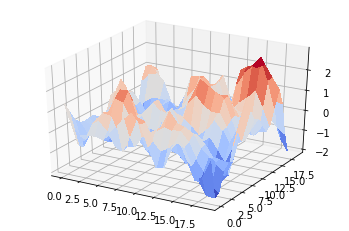

In [38]:
def make_mesh_grid(x_array: torch.Tensor, y_array: torch.Tensor):
    if torch.cuda.is_available():
        x_array = x_array.cuda()
        y_array = y_array.cuda()
    xv, yv = torch.meshgrid([x_array, y_array])
    points = torch.stack((xv, yv ), dim=-1).view(1,-1,2)  # shape: (batch=1, n, 2)
    return namedtuple("grid","xv yv points")._make([xv, yv, points])

def zero_mean(points):
    """ Input: points.shape = (*, n, D) 
        Output: mu.shape =  (*, n)  
        where batched_dimension * might or might not be present
    """
    independet_dim = points.shape[:-1]
    return torch.zeros(independet_dim, dtype=points.dtype, device=points.device)

def squared_exponential_kernel(points1, points2, length_scale=1.0):
    """ Input:
        points1.shape = (*, n, D)
        points2.shape = (*, m, D)
        Output: 
        C.shape = (*, n, m)
        where batched_dimension * might or might not be present
    """
    dim1 = points1.shape[-1]
    dim2 = points2.shape[-1]
    assert dim1 == dim2
    points1 = points1.unsqueeze(-2)  # *, n, 1, D
    points2 = points2.unsqueeze(-3)  # *, 1, m, D
    d2 = (points1-points2).pow(2).sum(dim=-1)  # *, n, m
    return torch.exp(-d2/length_scale)

def draw_from_GP(points, mean_func, conv_func):
    loc = mean_func(points)
    cov = conv_func(points,points)
    # print("loc ->",loc.shape)  # (*, n)
    # print("cov ->",cov.shape)  # (*, n, n)
    z = MultivariateNormal(loc=loc, covariance_matrix=cov).sample()
    assert z.shape == loc.shape
    return z

# Test
grid = make_mesh_grid(x_array=torch.arange(0,20).float(),
                      y_array=torch.arange(0,20).float())

zv = draw_from_GP(points=grid.points, 
                  mean_func=zero_mean, 
                  conv_func=partial(squared_exponential_kernel, length_scale=4))
print(zv.shape)
zv = zv.view_as(xv)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(grid.xv.cpu().numpy(), 
                       grid.yv.cpu().numpy(), 
                       zv.cpu().numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.show()

# Helper function to compute KL between multivariate Normal

In [39]:
def KL_multivariate_numerical(value, mu0, mu1, L_cov0, L_cov1):
    """ Input: value = (*, n) 
               mu0, mu1 = (*, n)
               L_cov0, L_cov1 = (*, n, n)
        Output: KL = (*) 
    """  
    log0 = MultivariateNormal(loc=mu0, scale_tril=L_cov0).log_prob(value)
    log1 = MultivariateNormal(loc=mu1, scale_tril=L_cov1).log_prob(value)
    return log0-log1

def KL_multivariate_numerical_average(Nav: int, 
                                      mu0: torch.Tensor,
                                      mu1: torch.Tensor, 
                                      L_cov0: torch.Tensor, 
                                      L_cov1: torch.Tensor):
    d = MultivariateNormal(loc=mu0, scale_tril=L_cov0)
    kl_av = 0
    for n in range(Nav):    
        value = d.rsample()    
        kl=KL_multivariate_numerical(value, mu0, mu1, L_cov0, L_cov1)    
        kl_av += kl
    return kl_av/Nav

def KL_multivariate_analytical_stupid(mu0: torch.Tensor,
                                      mu1: torch.Tensor,
                                      cov0: torch.Tensor,
                                      cov1: torch.Tensor):
    """ Input: mu0, mu1 = (*, n)
               cov0, cov1 = (*, n, n)
        Output: KL = (*) 
    """
    assert are_boradcastable(mu0, mu1)  # (*, n)
    assert are_boradcastable(cov0, cov1) # (*, n, n) 
    n = cov0.shape[-1]
    
    cov1_inverse = torch.inverse(cov1)  # (*, n, n)
    prod = torch.matmul(cov1_inverse,cov0) # (*, n, n)
    diag = torch.diagonal(prod,dim1=-1,dim2=-2) # (*, n)
    trace_term = diag.sum(dim=-1)  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    x = (mu1-mu0)  # (*, n)
    M_tmp = torch.matmul(cov1_inverse, x.unsqueeze(-1)) # (*, n, 1) = (*, n, n) (*, n, 1)
    square_term = torch.matmul(x.unsqueeze(-2), M_tmp)[...,0,0]  #  (*, 1, 1) = (*, 1, n) (*, n, 1) 
    #print("square_term",square_term.shape, square_term)
    
    logdet_term = torch.logdet(cov1) - torch.logdet(cov0) # (x)
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

def KL_multivariate_analytical_smart(mu0: torch.Tensor,
                                     mu1: torch.Tensor,
                                     L_cov0: torch.Tensor,
                                     L_cov1: torch.Tensor):
    assert are_boradcastable(mu0, mu1)  # (*, n)
    assert are_boradcastable(L_cov0, L_cov1)  # (*, n, n) 
    n = L_cov0.shape[-1]
    
    # Tr[cov1^(-1)cov0] = Tr[L L^T] = sum_of_element_wise_square(L) 
    # where L = L1^(-1) L0 -> Solve trilinear problem: L1 L = L0
    L = torch.triangular_solve(L_cov0, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,n)
    trace_term = torch.sum(L.pow(2), dim=(-1,-2))  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    # x^T conv1^(-1) x = z^T z where z = L1^(-1) x -> solve trilinear problem L1 z = x 
    dmu = (mu0-mu1).unsqueeze(-1)  # (*,n,1)
    z = torch.triangular_solve(dmu, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,1)
    # Now z.t*z is the sum over both n_points and dimension
    square_term = z.pow(2).sum(dim=(-1,-2))  # (*)
    #print("square_term",square_term.shape, square_term)
    
    # log[det(cov)]= log[det(L L^T)] = logdet(L) + logdet(L^T) = 2 logdet(L)
    # where logdet casn be computed as the sum of the diagonal elements
    logdet1 = torch.diagonal(L_cov1,dim1=-1,dim2=-2).log().sum(-1)
    logdet0 = torch.diagonal(L_cov0,dim1=-1,dim2=-2).log().sum(-1)
    logdet_term = 2 * (logdet1 - logdet0) # (*)  factor of 2 b/c log[det(L L^T)]= 2 log[det(L)]
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

# Test

In [40]:
grid = make_mesh_grid(x_array=torch.arange(0,20).double(),
                      y_array=torch.arange(0,20).double())
    
k = grid.points.shape[-1]
mu1 = zero_mean(grid.points)
mu0 = torch.randn_like(mu1)
cov1 = squared_exponential_kernel(grid.points, grid.points, length_scale=4.0)
sigma0 = F.softplus(torch.randn_like(mu1))
L_cov0 = torch.diag_embed(sigma0, dim1=-2, dim2=-1)
cov0 = torch.diag_embed(sigma0.pow(2), dim1=-2, dim2=-1)
L_cov1=torch.cholesky(cov1)

print("check ->",(torch.cholesky(cov0) - L_cov0).abs().max())

kl_analytical_stupid = KL_multivariate_analytical_stupid(mu0=mu0, 
                                                         mu1=mu1, 
                                                         cov0=cov0, 
                                                         cov1=cov1)
kl_analytical_smart = KL_multivariate_analytical_smart(mu0=mu0, 
                                                       mu1=mu1, 
                                                       L_cov0=L_cov0, 
                                                       L_cov1=L_cov1)
kl_numerical_average = KL_multivariate_numerical_average(Nav=1000,
                                                         mu0=mu0, 
                                                         mu1=mu1, 
                                                         L_cov0=L_cov0, 
                                                         L_cov1=L_cov1)

print(kl_analytical_stupid)
print(kl_analytical_smart)
print(kl_numerical_average)

check -> tensor(4.4409e-16, device='cuda:0', dtype=torch.float64)
tensor([9365250.2736], device='cuda:0', dtype=torch.float64)
tensor([9365250.2744], device='cuda:0', dtype=torch.float64)
tensor([9325021.6083], device='cuda:0', dtype=torch.float64)


# TRAIN UNDER KL

mu1 ---> torch.Size([1, 400]) cuda:0
cov1 ---> torch.Size([1, 400, 400]) cuda:0
zprior -> torch.Size([8, 400]) cuda:0


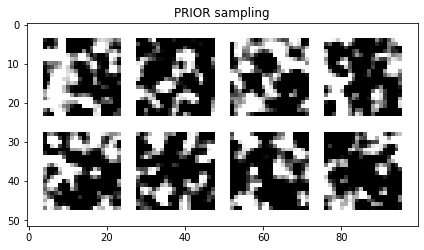

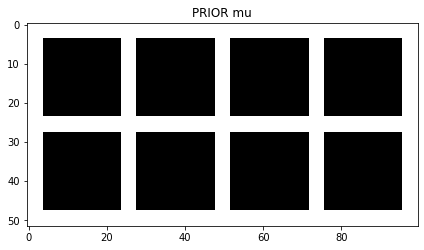

In [41]:
# Create grid
grid = make_mesh_grid(x_array=torch.arange(0,20).double(),
                      y_array=torch.arange(0,20).double())

# Sample prior
batch = 8
mu1 = zero_mean(grid.points)
cov1 = squared_exponential_kernel(grid.points, grid.points, length_scale=4.0)
zprior = MultivariateNormal(loc=mu1, covariance_matrix=cov1).expand([8]).sample()
print("mu1 --->",mu1.shape, mu1.device)
print("cov1 --->",cov1.shape, cov1.device)
print("zprior ->",zprior.shape, zprior.device)

# reshape to see the results
prior_z_img = show_batch(zprior.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="PRIOR sampling")
prior_mu_img = show_batch(mu1.expand([8,-1]).view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="PRIOR mu")
display(prior_z_img, prior_mu_img)

mu0 ---> torch.Size([8, 400]) cuda:0
sigma0 ---> torch.Size([8, 400]) cuda:0
z_posterior --> torch.Size([8, 400]) cuda:0


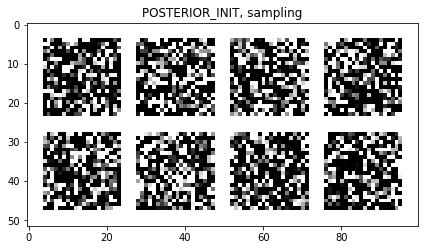

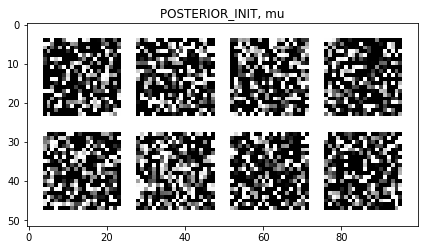

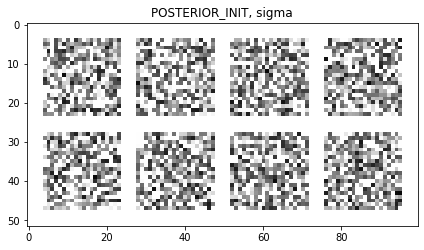

In [42]:
# the posterior is initialized at random
mu0_init = torch.randn_like(zprior).requires_grad_(False)
sigma0_init = F.softplus(torch.randn_like(zprior)).requires_grad_(False)
zposterior_init = Normal(loc=mu0_init, scale=sigma0_init).sample()

print("mu0 --->",mu0_init.shape, mu0_init.device)
print("sigma0 --->",sigma0_init.shape, sigma0_init.device)
print("z_posterior -->",zposterior_init.shape,zposterior_init.device)

# reshape to see the results
post_z_img_init = show_batch(zposterior_init.view([batch,1]+list(xv.shape)), 
                        n_col=4, n_padding=4, title="POSTERIOR_INIT, sampling")

post_mu_img_init = show_batch(mu0_init.view([batch,1]+list(xv.shape)), 
                         n_col=4, n_padding=4, title="POSTERIOR_INIT, mu")

post_sigma_img_init = show_batch(sigma0_init.view([batch,1]+list(xv.shape)), 
                        n_col=4, n_padding=4, title="POSTERIOR_INIT, sigma")

display(post_z_img_init, post_mu_img_init, post_sigma_img_init)

# Initialize the coarsening

In [43]:
L1_prior = torch.cholesky(cov1)
mu0 = mu0_init.clone().requires_grad_(True) 
sigma0 = sigma0_init.clone().requires_grad_(True) 
optimizer = torch.optim.Adam(params=[mu0, sigma0], lr = 1E-4)
loss_history = []
dir_output = "output_tmp"
# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

print(mu0)
print(sigma0)

tensor([[-1.3160,  0.0399,  1.4057,  ...,  0.8877,  0.5256,  1.3008],
        [ 0.8398, -0.2162,  0.5002,  ..., -0.2801,  1.2107, -1.8966],
        [ 0.1995,  0.1816,  0.6848,  ..., -0.8183, -0.4319,  1.8343],
        ...,
        [ 1.2494,  0.7940,  1.4462,  ...,  0.2930,  0.1747, -0.2998],
        [ 1.6409,  0.8433,  1.0952,  ..., -0.9625,  0.8919, -0.5907],
        [ 1.4140, -0.9718,  0.8862,  ..., -0.5658,  0.6049,  2.2188]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)
tensor([[0.6500, 0.8411, 1.9023,  ..., 0.5490, 0.8027, 0.2662],
        [0.7393, 0.3297, 0.6614,  ..., 0.9170, 1.4042, 0.9652],
        [1.1202, 0.6830, 0.6878,  ..., 0.3584, 1.5940, 0.5794],
        ...,
        [1.1820, 1.7466, 0.4900,  ..., 1.1942, 0.1322, 1.5385],
        [1.0461, 0.5924, 0.4573,  ..., 1.3463, 1.0088, 0.7440],
        [1.4051, 0.3414, 1.2064,  ..., 0.5339, 0.1886, 0.9933]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)


# Test differentiability

In [44]:
for epoch in range(100001):
    kl = KL_multivariate_analytical_smart(mu0=mu0, 
                                          mu1=mu1.detach(), 
                                          L_cov0=torch.diag_embed(sigma0, dim1=-2, dim2=-1), 
                                          L_cov1=L1_prior.detach())
    #kl = KL_multivariate_numerical(value=mu0+torch.randn_like(mu0)*sigma0,
    #                               mu0=mu0, 
    #                               mu1=mu1.detach(), 
    #                               L_cov0=torch.diag_embed(sigma0, dim1=-2, dim2=-1), 
    #                               L_cov1=L1_prior.detach())
    #
    #kl = square_term(mu0=mu0, mu1=mu1.detach(), L_cov1=L1_prior.detach())
    
    loss = kl.mean()
    loss_history.append(loss.detach().item())
    if epoch % 1000 == 0:
        print(epoch, loss)
        with torch.no_grad():
            if epoch < 10:
                l = '00000'+str(epoch)
            elif epoch < 100:
                l = '0000'+str(epoch)
            elif epoch < 1000:
                l = '000'+str(epoch)
            elif epoch < 10000:
                l = '00'+str(epoch)
            elif epoch < 100000:
                l = '0'+str(epoch)
            elif epoch < 1000000:
                l = str(epoch)
            else:
                raise Exception
                
            z = Normal(loc=mu0, scale=sigma0).sample()
            z_img = show_batch(z.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="z, epoch ="+l)
            mu_img = show_batch(mu0.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="mu, epoch ="+l)
            sigma_img = show_batch(sigma0.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="sigma, epoch ="+l)
            z_img.savefig(os.path.join(dir_output,"movie_z_"+l+".png"))
            mu_img.savefig(os.path.join(dir_output,"movie_mu_"+l+".png"))
            sigma_img.savefig(os.path.join(dir_output,"movie_sigma_"+l+".png"))
        
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()

0 tensor(10921985.3375, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_history,label="loss")
plt.grid()

In [ ]:
print(mu0_init)
print(mu0)
print(sigma0_init)
print(sigma0)

# MAKE THE MOVIE

In [ ]:
movie_z_filenames = glob.glob(dir_output+"/movie_z_*.png")
movie_mu_filenames = glob.glob(dir_output+"/movie_mu_*.png")
movie_sigma_filenames = glob.glob(dir_output+"/movie_sigma_*.png")
       
movie_z_filenames.sort()
movie_mu_filenames.sort()
movie_sigma_filenames.sort()

print(movie_z_filenames)
print(movie_mu_filenames)
print(movie_sigma_filenames)

In [ ]:
def show_frame_z(n):
    return Image(filename=movie_z_filenames[n])

def show_frame_mu(n):
    return Image(filename=movie_mu_filenames[n])

def show_frame_sigma(n):
    return display.Image(filename=movie_sigma_filenames[n])

def show_frame_all(n):
    try:
        a = Image(filename=movie_z_filenames[n])
        b = Image(filename=movie_mu_filename[n])
        c = Image(filename=movie_sigma_filenames[n])
        return display(a,b,c)
    except IndexError:
        print("list index out of range")
        pass

In [ ]:
show_frame_mu(0)

In [ ]:
show_frame_mu(50)

In [ ]:
movie_z_name = "movie_z.gif"
movie_mu_name = "movie_mu.gif"
movie_sigma_name = "movie_sigma.gif"

frame_per_second = 10

im = mpy.ImageSequenceClip(movie_z_filenames, fps=frame_per_second)
im.write_gif(movie_z_name, fps=frame_per_second)

im = mpy.ImageSequenceClip(movie_mu_filenames, fps=frame_per_second)
im.write_gif(movie_mu_name, fps=frame_per_second)

im = mpy.ImageSequenceClip(movie_sigma_filenames, fps=frame_per_second)
im.write_gif(movie_sigma_name, fps=frame_per_second)

In [ ]:
HTML("<img src="+movie_z_name+"></img>")

In [ ]:
HTML("<img src="+movie_mu_name+"></img>")

In [ ]:
HTML("<img src="+movie_sigma_name+"></img>")